In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import json
import os

In [6]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

In [23]:
class ImageExtractorIterator:
    def __init__(self, image_extractor_path: str, camera_list_file = "CameraList.json", cameras = [], image_filename = "BGRImage.jpg"):
        self.image_extractor_path = image_extractor_path
        self.camera_list_path = os.path.join(image_extractor_path, camera_list_file)
        self.cameras = cameras
        self.camera_id = 0
        self.image_id = 0
        self.image_filename = image_filename
        
        print(f"Reading camera list file: {self.camera_list_path}")
        with open(self.camera_list_path, 'r') as f:
            camera_list_data = json.load(f)
            self.images_filename = camera_list_data["ImagesFilename"]
            if not self.cameras:
                self.cameras = camera_list_data["Cameras"]
            else:
                for camera in self.cameras:
                    assert camera in camera_list_data["Cameras"], f"camera {camera} not found"

        self._get_current_images()

    def _get_current_images(self):
        self.current_images_list = []
        images_list_path = os.path.join(image_extractor_path, self.cameras[self.camera_id], f"{self.images_filename}.json")
        with open(images_list_path, 'r') as f:
            images_data = json.load(f)
            for image in images_data["Images"]:
                image_container_path = os.path.join(image_extractor_path, self.cameras[self.camera_id], f"{image}")
                assert os.path.exists(image_container_path), f"image container does not exist: {image_path}"
                image_path = os.path.join(image_container_path, self.image_filename)
                if os.path.exists(image_path):
                    self.current_images_list.append(image_path)
            
    def next(self):
        if self.image_id > len(self.current_images_list) - 1:
            self.camera_id += 1
            self.image_id = 0
            if self.camera_id > len(self.cameras) - 1:
                return None
            self._get_current_images()    

        return self.current_images_list[self.image_id]
            

Reading camera list file: /home/nick/d/results/image_extractor/CameraList.json


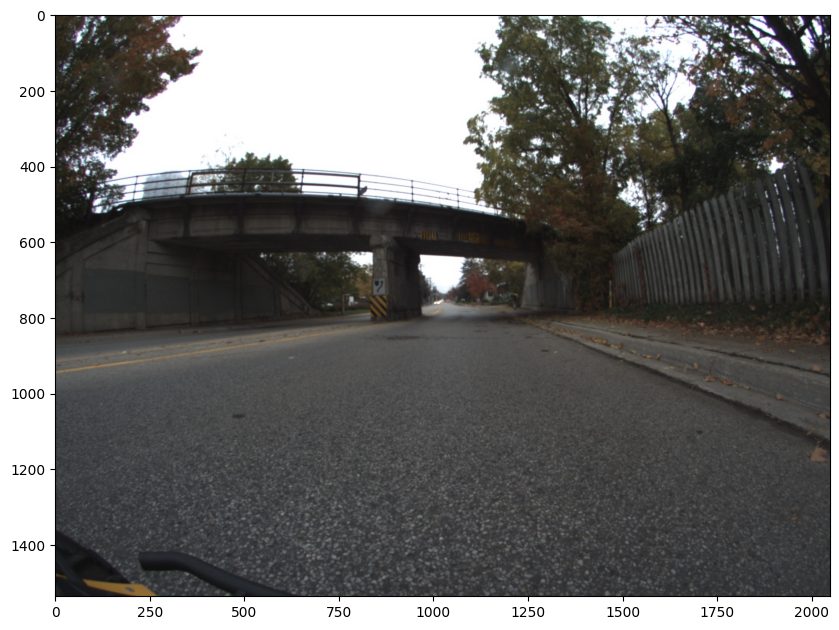

In [26]:
image_extractor_path = "/home/nick/d/results/image_extractor/"
selected_cameras = ["F1_link"]
image_iter = ImageExtractorIterator(
    image_extractor_path = image_extractor_path, 
    camera_list_file = "CameraList.json", 
    cameras = selected_cameras
) 


while True:
    image_path = image_iter.next()
    if image_path is None:
        break
            
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    plt.axis('on')
    plt.show()
    break